## 딥드림
- 합성곱 신경망이 학습한 표현을 사용하여 예술적으로 이미지를 조작
- 컨브넷 필터 시각화 기법과 유사
  - 컨브넷 상위 층에 있는 특정 필터의 활성화를 극대화하기 위해 컨브넷 입력에 경사 상승법을 적용
- 딥드림
  - 전체 층의 활성화를 최대화 : 한꺼번에 많은 특성을 섞어 시각화
  - 이미 가지고 있는 이미지 사용 : 기존 시각 패턴을 바탕으로 이미지의 요소들을 다소 예술적인 스타일로 왜곡
  - 시각 품질을 높이기 위해 여러 다른 스케일(octave)로 처리

### 케라스 딥드림 구현

**테스트 이미지 다운로드하기**

440742/440742 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


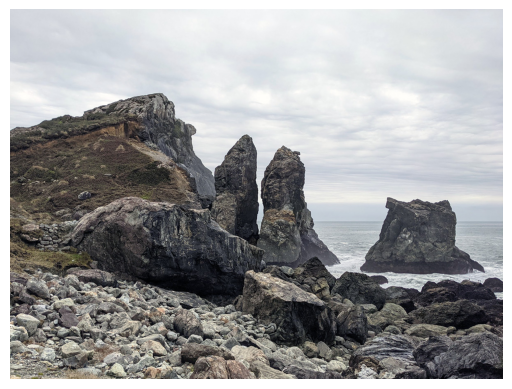

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**사전 훈련된 `InceptionV3` 모델 로드하기**  
- 어떤 컨브넷을 사용하느야에 따라 시각화에 영향

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**딥드림 손실에 대한 각 층의 기여도 설정하기**  
- 다양한 중간층의 활성화를 반환하는 특성 추출 모델
- 경사 상승법 단계 동안에 최대화활 손실에 대한 각 층의 기여도에 가중치를 주기 위해 스칼라 값 선택
- 다른 층을 선택하고 싶다면 `modle.summary()` 참고

In [4]:
# 활성화를 최대화할 층과 전체 손실에 대한 가중치
# 해당 설정을 바꾸면 새로운 시각 효과 생성
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# 각 층의 심볼릭 출력
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# 각 타겟 층의 활성화 값을 딕셔너리로 반환하는 모델
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**딥드림 손실**  
- 손실 계산 : 경사 상승법으로 각 스케일마다 최대화할 값
- 여러 층에 있는 모든 필터 활성화를 동시에 최대화
- 특히 상위 층에 있는 활성화의 L2 norm에 대한 가중치 편균을 최대화
- 하위 층은 기하학적인 패턴을 생성
- 상위 층은 ImageNet에 있는 클래스로 보이는 시각 요소를 생성

In [5]:
def compute_loss(input_image):
    # 활성화 추출
    features = feature_extractor(input_image)
    # 손실을 0으로 초기화
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # 경계 부근의 인공적인 패턴을 피하기 위해
        # 테두리가 아닌 픽셀만 손실에 추가
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**딥드림 경사 상승법 단계**

In [6]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    # 현재 이미지에 대한 딥드림 손실의 그레디언트를 계산
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    # 그레디언트 정규화
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

# 주어진 이미지 스케일(octave)에 대한 경사 상승법 수행
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    # 딥드림 손실을 증가시키는 방향으로 반복적으로 이미지 업데이트
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        # 손실이 일정 임계 값을 넘으면 중지
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

딥드림 알고리즘의 바깥쪽 루프
- 이미지 처리를 위한 옥타브 리스트 정의
  - **3개**의 다른 옥타브로 이미지 처리
  - 가장 작은 값에서 가장 큰 값까지 각 옥타브에서 `gradient_ascent_loop()`로 경사 상승법 단계를 **30번 실행**하여 손실을 최대화
  - 각 옥타브 사이에서는 이미지가 40% 증가 (**1.4배**)

In [7]:
step = 20.         # 경사 상승법 단계 크기
num_octave = 3     # 경사 상승법을 실행할 스케일 횟수
octave_scale = 1.4 # 연속적인 스케일 사이의 크기 비율
iterations = 30    # 스케일 단계마다 수행할 경사 상승법 단계 횟수
max_loss = 15.     # 이보다 손실이 커지면 중지

**이미지 처리 유틸리티**

In [8]:
import numpy as np

# 이미지를 로드하고 크기를 바구어 적절한 배열로 변환
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# 넘파이 배열을 이미지로 변환
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # InceptionV2 전처리 복원
    img += 1.0
    img *= 127.5
    # unit8로 변환하고 [0,255] 범위로 클리핑
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**연속적인 여러 개의 “옥타브"에 걸쳐 경사 상승법 실행하기**  
- 스케일을 연속적으로 증가시키면서 디테일을 많이 잃지 않도록 간단한 기교 사용 가능
  -

In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

(459, 612) 크기의 0번째 옥타브 처리


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 459, 612, 3))
  warnings.warn(msg)


... 스텝 0에서 손실 값: 0.80
... 스텝 1에서 손실 값: 1.07
... 스텝 2에서 손실 값: 1.44
... 스텝 3에서 손실 값: 1.82
... 스텝 4에서 손실 값: 2.16
... 스텝 5에서 손실 값: 2.49
... 스텝 6에서 손실 값: 2.84
... 스텝 7에서 손실 값: 3.19
... 스텝 8에서 손실 값: 3.52
... 스텝 9에서 손실 값: 3.87
... 스텝 10에서 손실 값: 4.21
... 스텝 11에서 손실 값: 4.55
... 스텝 12에서 손실 값: 4.90
... 스텝 13에서 손실 값: 5.27
... 스텝 14에서 손실 값: 5.59
... 스텝 15에서 손실 값: 5.97
... 스텝 16에서 손실 값: 6.28
... 스텝 17에서 손실 값: 6.65
... 스텝 18에서 손실 값: 6.96
... 스텝 19에서 손실 값: 7.29
... 스텝 20에서 손실 값: 7.59
... 스텝 21에서 손실 값: 7.93
... 스텝 22에서 손실 값: 8.25
... 스텝 23에서 손실 값: 8.58
... 스텝 24에서 손실 값: 8.88
... 스텝 25에서 손실 값: 9.17
... 스텝 26에서 손실 값: 9.42
... 스텝 27에서 손실 값: 9.71
... 스텝 28에서 손실 값: 9.98
... 스텝 29에서 손실 값: 10.23
(642, 857) 크기의 1번째 옥타브 처리


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 642, 857, 3))
  warnings.warn(msg)


... 스텝 0에서 손실 값: 1.60
... 스텝 1에서 손실 값: 2.65
... 스텝 2에서 손실 값: 3.47
... 스텝 3에서 손실 값: 4.06
... 스텝 4에서 손실 값: 4.61
... 스텝 5에서 손실 값: 5.09
... 스텝 6에서 손실 값: 5.56
... 스텝 7에서 손실 값: 5.98
... 스텝 8에서 손실 값: 6.38
... 스텝 9에서 손실 값: 6.75
... 스텝 10에서 손실 값: 7.10
... 스텝 11에서 손실 값: 7.45
... 스텝 12에서 손실 값: 7.78
... 스텝 13에서 손실 값: 8.09
... 스텝 14에서 손실 값: 8.41
... 스텝 15에서 손실 값: 8.70
... 스텝 16에서 손실 값: 9.02
... 스텝 17에서 손실 값: 9.27
... 스텝 18에서 손실 값: 9.55
... 스텝 19에서 손실 값: 9.84
... 스텝 20에서 손실 값: 10.11
... 스텝 21에서 손실 값: 10.35
... 스텝 22에서 손실 값: 10.60
... 스텝 23에서 손실 값: 10.82
... 스텝 24에서 손실 값: 11.09
... 스텝 25에서 손실 값: 11.31
... 스텝 26에서 손실 값: 11.57
... 스텝 27에서 손실 값: 11.75
... 스텝 28에서 손실 값: 11.98
... 스텝 29에서 손실 값: 12.15
(900, 1200) 크기의 2번째 옥타브 처리


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 900, 1200, 3))
  warnings.warn(msg)


... 스텝 0에서 손실 값: 1.49
... 스텝 1에서 손실 값: 2.32
... 스텝 2에서 손실 값: 3.02
... 스텝 3에서 손실 값: 3.54
... 스텝 4에서 손실 값: 3.99
... 스텝 5에서 손실 값: 4.39
... 스텝 6에서 손실 값: 4.79
... 스텝 7에서 손실 값: 5.13
... 스텝 8에서 손실 값: 5.50
... 스텝 9에서 손실 값: 5.81
... 스텝 10에서 손실 값: 6.13
... 스텝 11에서 손실 값: 6.41
... 스텝 12에서 손실 값: 6.70
... 스텝 13에서 손실 값: 6.98
... 스텝 14에서 손실 값: 7.25
... 스텝 15에서 손실 값: 7.49
... 스텝 16에서 손실 값: 7.78
... 스텝 17에서 손실 값: 8.01
... 스텝 18에서 손실 값: 8.26
... 스텝 19에서 손실 값: 8.47
... 스텝 20에서 손실 값: 8.70
... 스텝 21에서 손실 값: 8.91
... 스텝 22에서 손실 값: 9.16
... 스텝 23에서 손실 값: 9.34
... 스텝 24에서 손실 값: 9.60
... 스텝 25에서 손실 값: 9.72
... 스텝 26에서 손실 값: 9.97
... 스텝 27에서 손실 값: 10.13
... 스텝 28에서 손실 값: 10.36
... 스텝 29에서 손실 값: 10.52


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!ls

dream.png  gdrive  sample_data


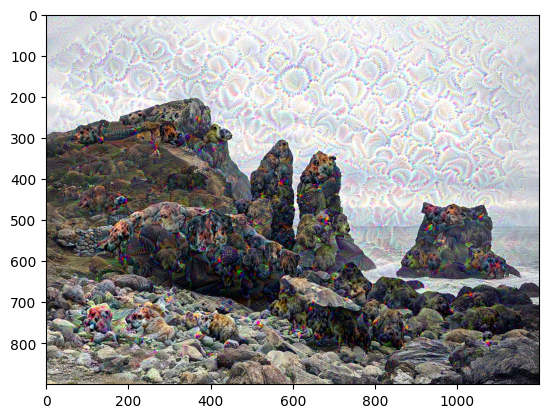

In [12]:
import cv2
deepdream = cv2.imread('dream.png')
deepdream = cv2.cvtColor(deepdream, cv2.COLOR_BGR2RGB)
plt.imshow(deepdream)
plt.show()

![dream.png](https://github.com/rickiepark/deep-learning-with-python-2nd/blob/main/dream.png?raw=1)

### 정리
- 네트워크가 학습한 표현을 기반으로 컨브넷을 거꾸로 실행하여 입력 이미지를 생성
- 이미지 모델이나 컨브넷에 국한되지 않고 음성, 음악 등에도 적용